In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def mostrar(img, cmap='gray', titulo=''):
    plt.imshow(img, cmap=cmap)
    plt.title(titulo)
    plt.axis('off')
    plt.show()

# 1. Cargar imagen
img = cv2.imread('sudoku.jpg')
img_original = img.copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 2. Preprocesar: desenfoque + umbral adaptativo
blur = cv2.GaussianBlur(gray, (7, 7), 3)
thresh = cv2.adaptiveThreshold(blur, 255, 
                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                cv2.THRESH_BINARY_INV, 11, 2)

# 3. Encontrar contornos
contornos, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 4. Filtrar el contorno más grande (debería ser el tablero)
contorno_tablero = max(contornos, key=cv2.contourArea)

# 5. Aproximar el contorno a un polígono (idealmente un cuadrado)
peri = cv2.arcLength(contorno_tablero, True)
approx = cv2.approxPolyDP(contorno_tablero, 0.02 * peri, True)

if len(approx) == 4:
    pts = approx.reshape(4, 2)
    
    # Ordenar puntos: superior izq, superior der, inf der, inf izq
    def ordenar_puntos(pts):
        suma = pts.sum(axis=1)
        resta = np.diff(pts, axis=1)

        ordenados = np.zeros((4, 2), dtype="float32")
        ordenados[0] = pts[np.argmin(suma)]
        ordenados[2] = pts[np.argmax(suma)]
        ordenados[1] = pts[np.argmin(resta)]
        ordenados[3] = pts[np.argmax(resta)]
        return ordenados

    pts_ordenados = ordenar_puntos(pts)

    # 6. Transformación de perspectiva
    lado = 450
    destino = np.array([[0, 0], [lado-1, 0], [lado-1, lado-1], [0, lado-1]], dtype="float32")
    M = cv2.getPerspectiveTransform(pts_ordenados, destino)
    warp = cv2.warpPerspective(img_original, M, (lado, lado))

    mostrar(warp, titulo='Tablero de Sudoku enderezado')
else:
    print("No se detectó un tablero cuadrado.")


No se detectó un tablero cuadrado.


Hay algunos problemas con la imagen, posibles soluciones serían:

    Conversión a escala de grises

    Ecualización del histograma

    Binarización más robusta (con cv2.THRESH_OTSU)

    Filtrado más riguroso de contornos

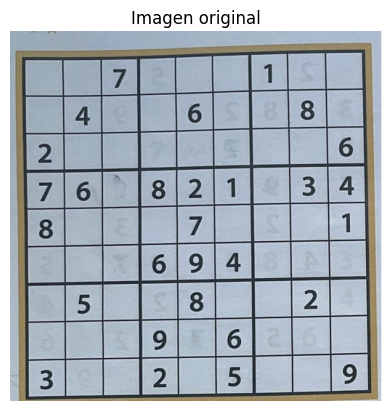

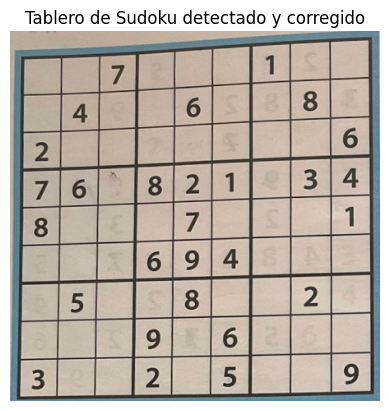

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Ruta a tu imagen
image_path = "sudoku.jpg"
img = cv2.imread(image_path)
img_original = img.copy()

# Escala de grises y ecualización
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_eq = cv2.equalizeHist(gray)
blur = cv2.GaussianBlur(gray_eq, (7, 7), 0)

# Binarización adaptativa con Otsu
_, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Buscar contornos
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Detectar el contorno cuadrado más grande
max_contour = None
max_area = 0
for cnt in contours:
    peri = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
    if len(approx) == 4 and cv2.contourArea(cnt) > max_area:
        max_area = cv2.contourArea(cnt)
        max_contour = approx

# Si se detecta correctamente el contorno
if max_contour is not None:
    pts = max_contour.reshape(4, 2)

    def ordenar_puntos(pts):
        suma = pts.sum(axis=1)
        resta = np.diff(pts, axis=1)
        ordenados = np.zeros((4, 2), dtype="float32")
        ordenados[0] = pts[np.argmin(suma)]
        ordenados[2] = pts[np.argmax(suma)]
        ordenados[1] = pts[np.argmin(resta)]
        ordenados[3] = pts[np.argmax(resta)]
        return ordenados

    pts_ordenados = ordenar_puntos(pts)
    destino = np.array([[0, 0], [449, 0], [449, 449], [0, 449]], dtype="float32")
    M = cv2.getPerspectiveTransform(pts_ordenados, destino)
    warp = cv2.warpPerspective(img_original, M, (450, 450))


    # Mostrar el original
    
    plt.imshow(img)
    plt.title("Imagen original")
    plt.axis("off")
    plt.show()


    # Mostrar el resultado
    plt.imshow(cv2.cvtColor(warp, cv2.COLOR_BGR2RGB))
    
    plt.title("Tablero de Sudoku detectado y corregido")
    plt.axis("off")
    plt.show()
else:
    print("No se detectó un tablero cuadrado.")


Ahora necesitamos evaluar cada celda. Para ello tendremos que separarlas antes de detectar el valor en el interior

In [9]:
import os
import cv2

# Crear carpeta para guardar las celdas
os.makedirs("celdas_sudoku", exist_ok=True)

# Dimensiones del tablero aplanado
alto_total, ancho_total = warp.shape[:2]
tam_celda_x = ancho_total // 9
tam_celda_y = alto_total // 9

# Cortar y guardar las 81 celdas
celdas = []
for fila in range(9):
    for col in range(9):
        x1 = col * tam_celda_x
        y1 = fila * tam_celda_y
        x2 = (col + 1) * tam_celda_x
        y2 = (fila + 1) * tam_celda_y
        celda = warp[y1:y2, x1:x2]

        # Convertir a escala de grises y ajustar tamaño (por ejemplo, 28x28)
        celda_gray = cv2.cvtColor(celda, cv2.COLOR_BGR2GRAY)
        celda_resized = cv2.resize(celda_gray, (28, 28), interpolation=cv2.INTER_AREA)

        # Guardar la celda
        nombre = f"celdas_sudoku/celda_{fila}_{col}.png"
        cv2.imwrite(nombre, celda_resized)

        celdas.append(celda_resized)

print(f"Guardadas {len(celdas)} celdas en la carpeta 'celdas_sudoku'")


Guardadas 81 celdas en la carpeta 'celdas_sudoku'


In [10]:
# Parámetro: cuánto recortar del borde (5% por cada lado)
recorte_ratio = 0.05

# Cortar y guardar las celdas centradas
os.makedirs("celdas_recortadas", exist_ok=True)
celdas = []

for fila in range(9):
    for col in range(9):
        x1 = col * tam_celda_x
        y1 = fila * tam_celda_y
        x2 = (col + 1) * tam_celda_x
        y2 = (fila + 1) * tam_celda_y

        # Recorte interno para evitar bordes negros
        dx = int(tam_celda_x * recorte_ratio)
        dy = int(tam_celda_y * recorte_ratio)
        celda = warp[y1 + dy:y2 - dy, x1 + dx:x2 - dx]

        # Convertir a grises y escalar a 28x28
        celda_gray = cv2.cvtColor(celda, cv2.COLOR_BGR2GRAY)
        celda_resized = cv2.resize(celda_gray, (28, 28), interpolation=cv2.INTER_AREA)

        nombre = f"celdas_recortadas/celda_{fila}_{col}.png"
        cv2.imwrite(nombre, celda_resized)
        celdas.append(celda_resized)


Seguimos teniendo problemas con el recorte de las celdas. Ahora tenemos dos opciones. O conseguir que la imagen esté más limpia, o binarizar. Imaginemos que no podemos tener acceso a la imagen original. 

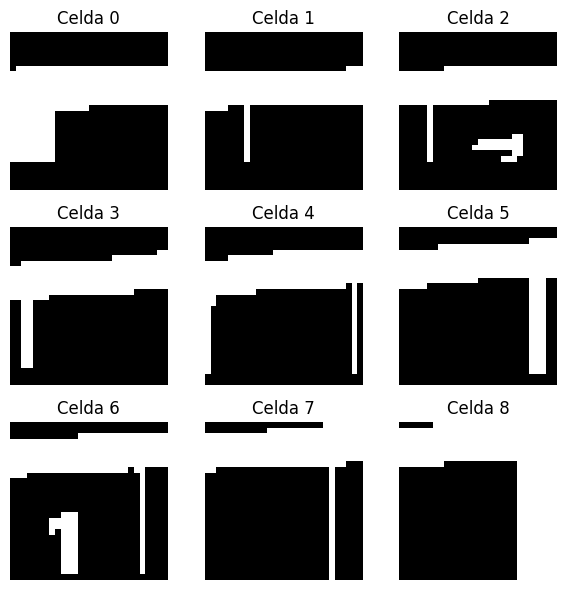

In [11]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

# 🧱 Función que limpia y centra el dígito en la celda
def procesar_celda(celda_bgr):
    gray = cv2.cvtColor(celda_bgr, cv2.COLOR_BGR2GRAY)
    _, binarizada = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    contornos, _ = cv2.findContours(binarizada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contornos:
        contorno = max(contornos, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(contorno)

        recorte = binarizada[y:y+h, x:x+w]
        lado_max = max(w, h)
        lienzo = np.zeros((lado_max, lado_max), dtype=np.uint8)
        x_offset = (lado_max - w) // 2
        y_offset = (lado_max - h) // 2
        lienzo[y_offset:y_offset+h, x_offset:x_offset+w] = recorte

        final = cv2.resize(lienzo, (28, 28), interpolation=cv2.INTER_NEAREST)
    else:
        final = np.zeros((28, 28), dtype=np.uint8)

    return final

# ⚙️ Cortar celdas desde el tablero "warp"
def extraer_celdas(warp):
    alto_total, ancho_total = warp.shape[:2]
    tam_celda_x = ancho_total // 9
    tam_celda_y = alto_total // 9

    os.makedirs("celdas_procesadas", exist_ok=True)
    celdas = []

    for fila in range(9):
        for col in range(9):
            x1 = col * tam_celda_x
            y1 = fila * tam_celda_y
            x2 = (col + 1) * tam_celda_x
            y2 = (fila + 1) * tam_celda_y

            celda = warp[y1:y2, x1:x2]
            celda_limpia = procesar_celda(celda)

            nombre = f"celdas_procesadas/celda_{fila}_{col}.png"
            cv2.imwrite(nombre, celda_limpia)
            celdas.append(celda_limpia)

    return celdas

# 🔄 Ejecutar el procesamiento
celdas_procesadas = extraer_celdas(warp)

# 🖼️ Mostrar algunas celdas
plt.figure(figsize=(6, 6))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(celdas_procesadas[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Celda {i}')
plt.tight_layout()
plt.show()


Sigue sin ser optimo, así que vamos a combinar:

    Detección de dígito con análisis de área blanca (cuánto ocupa el número)

    Si detectamos que la celda tiene un número, hacemos recorte automático sobre su zona

    Si no, la tratamos como celda vacía (todo negro)

In [28]:
def procesar_celda_mejorada(celda_bgr, umbral_min_area=50):
    gray = cv2.cvtColor(celda_bgr, cv2.COLOR_BGR2GRAY)
    _, binaria = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((2,2), np.uint8)
    binaria = cv2.erode(binaria, kernel)

    contornos, _ = cv2.findContours(binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contornos:
        contorno = max(contornos, key=cv2.contourArea)
        area = cv2.contourArea(contorno)
        if area > umbral_min_area:
            x, y, w, h = cv2.boundingRect(contorno)
            recorte = binaria[y:y+h, x:x+w]
            tam_max = max(w, h)
            lienzo = np.zeros((tam_max, tam_max), dtype=np.uint8)
            x_offset = (tam_max - w) // 2
            y_offset = (tam_max - h) // 2
            lienzo[y_offset:y_offset+h, x_offset:x_offset+w] = recorte
            return cv2.resize(lienzo, (28, 28), interpolation=cv2.INTER_NEAREST)
    return np.zeros((28, 28), dtype=np.uint8)


In [29]:
os.makedirs("celdas_procesadas", exist_ok=True)
celdas_procesadas = []

alto_total, ancho_total = warp.shape[:2]
tam_celda_x = ancho_total // 9
tam_celda_y = alto_total // 9

for fila in range(9):
    for col in range(9):
        x1 = col * tam_celda_x
        y1 = fila * tam_celda_y
        x2 = (col + 1) * tam_celda_x
        y2 = (fila + 1) * tam_celda_y
        celda = warp[y1:y2, x1:x2]
        celda_limpia = procesar_celda_mejorada(celda)
        cv2.imwrite(f"celdas_procesadas/celda_{fila}_{col}.png", celda_limpia)
        celdas_procesadas.append(celda_limpia)



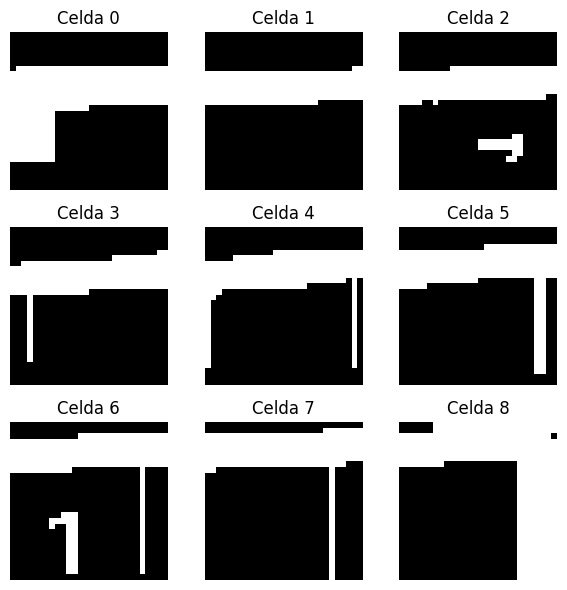

In [31]:
plt.figure(figsize=(6, 6))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(celdas_procesadas[i], cmap='gray')
    plt.title(f"Celda {i}")
    plt.axis('off')
plt.tight_layout()
plt.show()


Sigue sin ser optimo, probemos entonces mejorando contraste

In [38]:
def mejorar_contraste_con_clahe(imagen_bgr):
    gris = cv2.cvtColor(imagen_bgr, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    mejorada = clahe.apply(gris)
    return mejorada


In [39]:
def extraer_digito_con_contraste(celda_bgr, area_minima=50):
    gris_clahe = mejorar_contraste_con_clahe(celda_bgr)
    borrosa = cv2.GaussianBlur(gris_clahe, (3, 3), 0)
    _, binaria = cv2.threshold(borrosa, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Erosión ligera para eliminar bordes del marco
    binaria = cv2.erode(binaria, np.ones((2, 2), np.uint8), iterations=1)

    contornos, _ = cv2.findContours(binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contornos:
        contorno = max(contornos, key=cv2.contourArea)
        area = cv2.contourArea(contorno)
        if area > area_minima:
            x, y, w, h = cv2.boundingRect(contorno)
            recorte = binaria[y:y+h, x:x+w]
            tam_max = max(w, h)
            lienzo = np.zeros((tam_max, tam_max), dtype=np.uint8)
            x_offset = (tam_max - w) // 2
            y_offset = (tam_max - h) // 2
            lienzo[y_offset:y_offset+h, x_offset:x_offset+w] = recorte
            return cv2.resize(lienzo, (28, 28), interpolation=cv2.INTER_NEAREST)
    return np.zeros((28, 28), dtype=np.uint8)


In [42]:
celdas_mejoradas = []
os.makedirs("celdas_contrastadas", exist_ok=True)

for fila in range(9):
    for col in range(9):
        x1 = col * tam_celda_x
        y1 = fila * tam_celda_y
        x2 = (col + 1) * tam_celda_x
        y2 = (fila + 1) * tam_celda_y
        celda = warp[y1:y2, x1:x2]
        limpia = extraer_digito_con_contraste(celda)
        celdas_mejoradas.append(limpia)
        cv2.imwrite(f"celdas_contrastadas/celda_{fila}_{col}.png", limpia)


Tampoco es optimo, así que vamos con una imagen más limpia, he corregido la inclinación, brillo y contraste

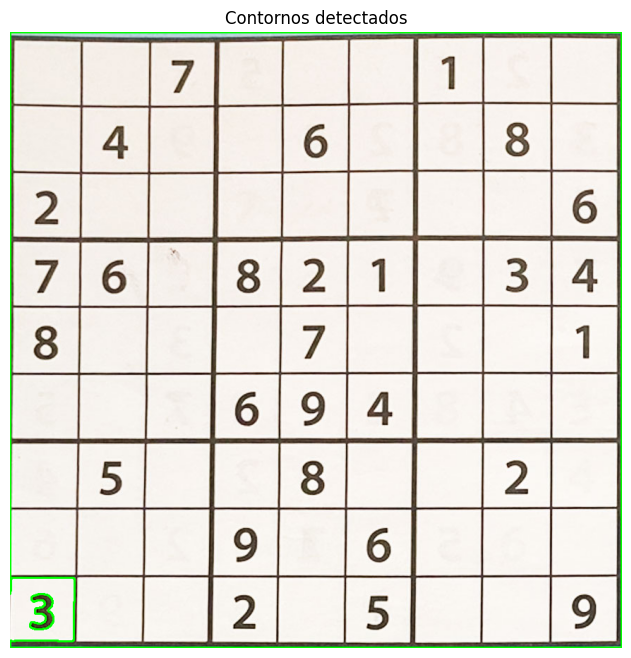

No se encontró contorno de 4 lados, usando bounding box grande.


In [55]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = "sudoku2.jpg"
img = cv2.imread(image_path)
img_original = img.copy()

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_eq = cv2.equalizeHist(gray)
blur = cv2.GaussianBlur(gray_eq, (7, 7), 0)

_, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

max_contour = None
max_area = 0
for cnt in contours:
    peri = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)  # MÁS TOLERANTE
    if len(approx) == 4 and cv2.contourArea(cnt) > max_area:
        max_area = cv2.contourArea(cnt)
        max_contour = approx

img_contornos = img.copy()
cv2.drawContours(img_contornos, contours, -1, (0, 255, 0), 2)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img_contornos, cv2.COLOR_BGR2RGB))
plt.title("Contornos detectados")
plt.axis("off")
plt.show()

# Si no se encuentra un contorno con 4 puntos, usar bounding box
if max_contour is None:
    print("No se encontró contorno de 4 lados, usando bounding box grande.")
    x, y, w, h = cv2.boundingRect(np.vstack(contours))
    pts_ordenados = np.array([
        [x, y],
        [x + w, y],
        [x + w, y + h],
        [x, y + h]
    ], dtype="float32")
else:
    pts = max_contour.reshape(4, 2)

    def ordenar_puntos(pts):
        suma = pts.sum(axis=1)
        resta = np.diff(pts, axis=1)
        ordenados = np.zeros((4, 2), dtype="float32")
        ordenados[0] = pts[np.argmin(suma)]
        ordenados[2] = pts[np.argmax(suma)]
        ordenados[1] = pts[np.argmin(resta)]
        ordenados[3] = pts[np.argmax(resta)]
        return ordenados

    pts_ordenados = ordenar_puntos(pts)

    destino = np.array([[0, 0], [449, 0], [449, 449], [0, 449]], dtype="float32")
    M = cv2.getPerspectiveTransform(pts_ordenados, destino)

    warp = cv2.warpPerspective(img_original, M, (450, 450), flags=cv2.INTER_NEAREST)  # <-- INTER_NEAREST

    # Mostrar resultados
    plt.imshow(cv2.cvtColor(warp, cv2.COLOR_BGR2RGB))
    plt.title("Tablero corregido con bordes nítidos")
    plt.axis("off")
    plt.show()


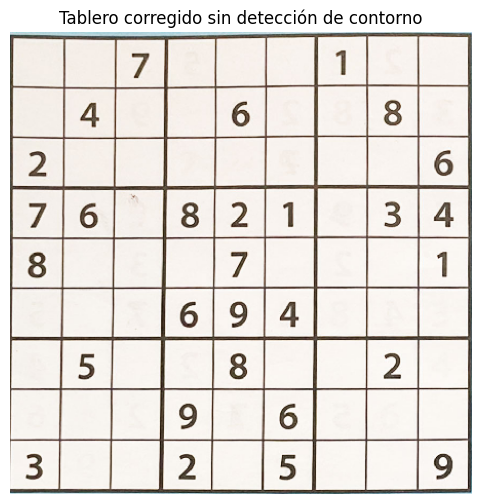

In [56]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Cargar imagen
image_path = "sudoku2.jpg"
img = cv2.imread(image_path)
img_original = img.copy()
alto, ancho = img.shape[:2]

# Definir las esquinas manualmente
pts_ordenados = np.array([
    [0, 0],
    [ancho - 1, 0],
    [ancho - 1, alto - 1],
    [0, alto - 1]
], dtype="float32")

# Definir destino cuadrado uniforme (450x450)
destino = np.array([
    [0, 0],
    [449, 0],
    [449, 449],
    [0, 449]
], dtype="float32")

# Transformación de perspectiva forzada
M = cv2.getPerspectiveTransform(pts_ordenados, destino)
warp = cv2.warpPerspective(img_original, M, (450, 450), flags=cv2.INTER_NEAREST)

# Mostrar resultado
plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(warp, cv2.COLOR_BGR2RGB))
plt.title("Tablero corregido sin detección de contorno")
plt.axis("off")
plt.show()


In [57]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 📦 Asegura que warp está generado correctamente antes de esto

# Función: mejora local con CLAHE
def mejorar_contraste_con_clahe(imagen_bgr):
    gris = cv2.cvtColor(imagen_bgr, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(gris)

# Función: extrae el dígito centrado en blanco sobre negro
def extraer_digito_con_contraste(celda_bgr, area_minima=50):
    gris_clahe = mejorar_contraste_con_clahe(celda_bgr)
    borrosa = cv2.GaussianBlur(gris_clahe, (3, 3), 0)
    _, binaria = cv2.threshold(borrosa, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    binaria = cv2.erode(binaria, np.ones((2, 2), np.uint8), iterations=1)

    contornos, _ = cv2.findContours(binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contornos:
        contorno = max(contornos, key=cv2.contourArea)
        area = cv2.contourArea(contorno)
        if area > area_minima:
            x, y, w, h = cv2.boundingRect(contorno)
            recorte = binaria[y:y+h, x:x+w]
            tam_max = max(w, h)
            lienzo = np.zeros((tam_max, tam_max), dtype=np.uint8)
            x_offset = (tam_max - w) // 2
            y_offset = (tam_max - h) // 2
            lienzo[y_offset:y_offset+h, x_offset:x_offset+w] = recorte
            return cv2.resize(lienzo, (28, 28), interpolation=cv2.INTER_NEAREST)
    return np.zeros((28, 28), dtype=np.uint8)

# 📌 Cortar el warp en 9x9 celdas y procesarlas
alto_total, ancho_total = warp.shape[:2]
tam_celda_x = ancho_total // 9
tam_celda_y = alto_total // 9

os.makedirs("celdas_finales", exist_ok=True)
celdas_procesadas = []

for fila in range(9):
    for col in range(9):
        x1 = col * tam_celda_x
        y1 = fila * tam_celda_y
        x2 = (col + 1) * tam_celda_x
        y2 = (fila + 1) * tam_celda_y
        celda = warp[y1:y2, x1:x2]
        limpia = extraer_digito_con_contraste(celda)
        cv2.imwrite(f"celdas_finales/celda_{fila}_{col}.png", limpia)
        celdas_procesadas.append(limpia)

print("✅ Celdas extraídas y guardadas. Total:", len(celdas_procesadas))


✅ Celdas extraídas y guardadas. Total: 81


Probamos con un modelo preentrenado, con MNIST

In [32]:
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Entrenar un modelo si no lo tienes
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0
X_test = X_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=3, batch_size=128, validation_split=0.1)


c:\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8333 - loss: 0.5733 - val_accuracy: 0.9803 - val_loss: 0.0710
Epoch 2/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9770 - loss: 0.0741 - val_accuracy: 0.9820 - val_loss: 0.0647
Epoch 3/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9844 - loss: 0.0507 - val_accuracy: 0.9880 - val_loss: 0.0476


Probamos el modelo en nuestras celdas

In [116]:
def es_celda_vacia(img, umbral_pixeles_blancos=151, umbral_brillo=0.99):
    # La imagen debe estar normalizada entre 0 y 1
    
    blancos = np.count_nonzero(img > umbral_brillo)
    print("bñancos", blancos)
    return blancos < umbral_pixeles_blancos

In [117]:
def predecir_celda(img, modelo, umbral=80):
    norm = celda.astype("float32") / 255.0
    
    if es_celda_vacia(norm):  # ⬅ ahora es mucho más preciso
        return 0
    entrada = norm.reshape(1, 28, 28, 1)
    salida = modelo.predict(entrada, verbose=0)
    return int(np.argmax(salida))


In [97]:
tablero = np.array(predicciones).reshape(9, 9)
print("Tablero detectado:")
print(tablero)


Tablero detectado:
[[9 9 9 9 9 9 9 9 9]
 [9 9 9 9 9 9 9 9 9]
 [9 9 9 9 9 9 9 9 9]
 [9 9 9 9 9 9 9 9 9]
 [9 9 9 9 9 9 9 9 9]
 [9 9 9 9 9 9 9 9 9]
 [9 9 9 9 9 9 9 9 9]
 [9 9 9 9 9 9 9 9 9]
 [9 9 9 9 9 9 9 9 9]]


In [ ]:
""""
el resultado esperado sería 
tablero_inicial = [
    [0, 0, 7, 0, 0, 0, 1, 0, 0],
    [0, 4, 0, 0, 6, 0, 0, 8, 0],
    [2, 0, 0, 0, 0, 0, 0, 0, 6],
    [7, 6, 0, 8, 2, 1, 0, 3, 4],
    [8, 0, 0, 0, 7, 0, 0, 0, 1],
    [0, 0, 0, 6, 9, 4, 0, 0, 0],
    [0, 5, 0, 0, 8, 0, 0, 2, 0],
    [0, 0, 0, 9, 0, 6, 0, 0, 0],
    [3, 0, 0, 2, 0, 5, 0, 0, 9]
   
]
"""

Habría que iterar hasta conseguir que detecte bien la imagen, pasándola cuanto más limpia y alineada al inicio mejor

Está dando malos resultados porque MNIST entrena con digitos escritos a mano, así que vamos a usar un modelo preentrenado con dígitos impresos (https://github.com/kaydee0502/printed-digits-dataset/tree/master)

In [126]:
import tensorflow as tf

# Cargar el modelo
modelo = tf.keras.models.load_model("model/v2_printed_digits_cnn.h5")

# Ver resumen
modelo.summary()


c:\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 1, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 692,684 (2.64 MB)

 Trainable params: 691,786 (2.64 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 2 (12.00 B)

In [127]:
import numpy as np

def predecir_celda_con_modelo(celda, modelo):
    entrada = celda.astype("float32") / 255.0
    entrada = entrada.reshape(1, 28, 28, 1)  # Añadir batch y canal
    salida = modelo.predict(entrada, verbose=0)
    return int(np.argmax(salida))


In [128]:
tablero = np.array([predecir_celda_con_modelo(c, modelo) for c in celdas_procesadas]).reshape(9, 9)
print("Tablero detectado:")
print(tablero)


Tablero detectado:
[[1 7 7 1 1 7 7 1 1]
 [1 4 7 1 6 1 1 8 1]
 [2 1 1 1 1 1 1 1 6]
 [7 6 1 8 2 7 1 3 4]
 [8 1 1 1 7 1 1 1 7]
 [1 1 1 6 9 4 1 1 1]
 [1 5 1 1 8 1 1 2 1]
 [1 1 1 9 1 6 1 1 1]
 [3 1 1 3 1 5 1 1 2]]


# STOP: Momento de parar y pensar!!!!!!

El resultado sigue sin ser satisfactorio. ¿Cómo podemos mejorarlo? Esta es la parte del ejercicio donde deberíais incidir más. Posibles alternativas: 

   - Probar con más modelos preentrenados
   - Entrenar a partir de un modelo
   - Realizar el entrenamiento completo nosotros. 
   - Usar técnicas mixtas, con k-means, por ejemplo

Consejo: 
  - Modularizar los problemas. Realizar pruebas con imágenes aisladas. Hicimos ejercicios parecidos con ML, quizás sería el momento de echarles un vistazo

# Una ver resuelto el problema de reconocimiento de dígitos, podemos pasar a la siguiente fase

Un posible solver sería este

In [35]:
def es_valido(tablero, fila, col, num):
    for i in range(9):
        if tablero[fila][i] == num or tablero[i][col] == num:
            return False

    # Subcuadro 3x3
    inicio_fila = (fila // 3) * 3
    inicio_col = (col // 3) * 3
    for i in range(inicio_fila, inicio_fila + 3):
        for j in range(inicio_col, inicio_col + 3):
            if tablero[i][j] == num:
                return False
    return True


def resolver_con_pasos(tablero):
    pasos = []

    def backtrack():
        for fila in range(9):
            for col in range(9):
                if tablero[fila][col] == 0:
                    for num in range(1, 10):
                        if es_valido(tablero, fila, col, num):
                            tablero[fila][col] = num
                            pasos.append((fila, col, num))  # Guardar paso
                            if backtrack():
                                return True
                            tablero[fila][col] = 0  # Backtrack
                            pasos.pop()  # Eliminar paso incorrecto
                    return False
        return True

    exito = backtrack()
    return pasos if exito else None


In [37]:
tablero_inicial = [
    [0, 0, 7, 0, 0, 0, 1, 0, 0],
    [0, 4, 0, 0, 6, 0, 0, 8, 0],
    [2, 0, 0, 0, 0, 0, 0, 0, 6],
    [7, 6, 0, 8, 2, 1, 0, 3, 4],
    [8, 0, 0, 0, 7, 0, 0, 0, 1],
    [0, 0, 0, 6, 9, 4, 0, 0, 0],
    [0, 5, 0, 0, 8, 0, 0, 2, 0],
    [0, 0, 0, 9, 0, 6, 0, 0, 0],
    [3, 0, 0, 2, 0, 5, 0, 0, 9]
   
]

# Hacemos una copia para no alterar el original
import copy
tablero = copy.deepcopy(tablero_inicial)

pasos = resolver_con_pasos(tablero)

if pasos:
    print(f"Número de pasos: {len(pasos)}")
    print("Primeros 5 pasos:")
    for p in pasos[:5]:
        print(f"Coloca un {p[2]} en fila {p[0]+1}, columna {p[1]+1}")
else:
    print("No se encontró solución.")


Número de pasos: 52
Primeros 5 pasos:
Coloca un 6 en fila 1, columna 1
Coloca un 8 en fila 1, columna 2
Coloca un 3 en fila 1, columna 4
Coloca un 4 en fila 1, columna 5
Coloca un 9 en fila 1, columna 6
